## Import Library 

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Hugging Face를 통한 모델 및 토크나이저 Import
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup


## Load Data

In [43]:
df = pd.read_csv("../preprocessing/preprocessed_title.csv", index_col = 0)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9423 entries, 0 to 9781
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            9423 non-null   object
 1   label            9423 non-null   int64 
 2   processed_title  9423 non-null   object
dtypes: int64(1), object(2)
memory usage: 294.5+ KB


In [45]:
df = df.dropna(subset=['processed_title'])

In [46]:
device = torch.device("cuda:0")

## Load Model

In [47]:
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Build Dataset

In [48]:
class KLUE_DATASET(Dataset):
    def __init__(self, dataset, tokenizer):
        
        self.dataset = dataset
        self.tokenizer = tokenizer
    
    def __len__(self):
        
        return len(self.dataset)
    
    def __getitem__(self, idx):
        
        sample = self.dataset.iloc[idx] 
        text = str(sample['processed_title'])
        label = int(sample['label'])

        # 토크나이징
        tokens = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128, # 최대 길이 지정
            return_tensors="pt" # PyTorch 텐서 반환
        )

        # 하나의 sample의 정보를 dictionary로 구성
        return {
            'text': text,
            'input_ids': tokens['input_ids'].squeeze(0), # (batch_size=1, size)이므로 squeeze(0)으로 1인 차원 축소
            'token_type_ids': tokens['token_type_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'labels': label
        }

In [49]:
# test for KLUE dataset
test = KLUE_DATASET(df, tokenizer)
print(test[0])

{'text': '재학생 영어 진단 평가 신청 일정 안내', 'input_ids': tensor([   2, 9155, 2065, 4612, 5169, 3777, 4373, 4362, 5611,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Split Data

In [50]:
# 데이터 분할
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.1)
train_dataset = KLUE_DATASET(train_data, tokenizer)
eval_dataset = KLUE_DATASET(test_data, tokenizer)

In [51]:
print(len(train_dataset))
print(len(eval_dataset))

8480
943


## DataLoader

In [52]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 8
train_dataloader = DataLoader(
    train_dataset, 
    sampler = RandomSampler(train_dataset),
    batch_size = BATCH_SIZE
)
eval_dataloader = DataLoader(
    eval_dataset, 
    sampler = RandomSampler(eval_dataset),
    batch_size = BATCH_SIZE
)

## Optimizer & Learning Scheduler

In [53]:
optimizer = AdamW(model.parameters(), 
                  lr = 2e-5, 
                  eps = 1e-8)

num_epochs = 5
# len(dataloader) = len(dataset)/batch_size
total_steps = len(train_dataloader)*num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

/home/aix7101/anaconda3/envs/euron/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training Loop

In [54]:
def calcuate_accuracy(preds, labels):
    preds = np.argmax(preds, axis = 1)
    return np.sum(preds == labels) / len(labels)

In [55]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [56]:
training_info = []

for epoch in range(num_epochs):
    
    print(f"======Epoch {epoch+1} / {num_epochs}======")
    print("Training...")
    
    total_train_loss = 0.0
    
    model.train()
    
    for idx, sample in enumerate(train_dataloader):
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        labels = sample['labels'].to(device)
        
        optimizer.zero_grad() # initialize gradient
        outputs = model(input_ids,
                             token_type_ids = None,
                             attention_mask = attention_mask,
                             labels = labels)
        # print(f"outputs: {outputs}")
        
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward() # compute gradient based on loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() # update weights based on computed gradients
        scheduler.step() # reschedule learning rate
    
    avg_train_loss = total_train_loss / len(train_dataloader) # 전체 데이터셋의 loss / 반복의 횟수
    
    print(f"Average training loss: {avg_train_loss:.4f}")
    print("Validation...")
    
    model.eval()
    
    total_eval_accuracy = 0.0
    total_eval_loss = 0.0
    
    for _, sample in enumerate(eval_dataloader):
        
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        labels = sample['labels'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, 
                            token_type_ids = None,
                            attention_mask = attention_mask,
                            labels = labels)
            loss = outputs.loss
            total_eval_loss += loss.item()
            
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()
            
            total_eval_accuracy += calcuate_accuracy(logits, labels)
    
    avg_eval_loss = total_eval_loss / len(eval_dataloader)
    avg_eval_accuracy = total_eval_accuracy / len(eval_dataloader)
    print(f"Validation Loss: {avg_eval_loss:.4f}")
    print(f"Validation Accuracy: {avg_eval_accuracy:.4f}")
    
    training_info.append(
        {
            'epoch': epoch + 1,
            'training loss': avg_train_loss,
            'eval loss': avg_eval_loss,
            'eval accuracy': avg_eval_accuracy
        }
    )
    print('\n')

print("Training Completed")

======Epoch 1 / 5======
Training...


Average training loss: 0.2992
Validation...
Validation Loss: 0.2537
Validation Accuracy: 0.9417


======Epoch 2 / 5======
Training...
Average training loss: 0.1640
Validation...
Validation Loss: 0.2291
Validation Accuracy: 0.9490


======Epoch 3 / 5======
Training...
Average training loss: 0.1075
Validation...
Validation Loss: 0.2500
Validation Accuracy: 0.9522


======Epoch 4 / 5======
Training...
Average training loss: 0.0628
Validation...
Validation Loss: 0.2990
Validation Accuracy: 0.9502


======Epoch 5 / 5======
Training...
Average training loss: 0.0413
Validation...
Validation Loss: 0.3159
Validation Accuracy: 0.9458


Training Completed


## Visualization

In [57]:
df_train_info = pd.DataFrame(data = training_info)
df_train_info = df_train_info.set_index('epoch')
df_train_info

,training loss,eval loss,eval accuracy
epoch,,,
1,0.299225,0.253746,0.941737
2,0.164004,0.229142,0.949001
3,0.107500,0.249960,0.952179
4,0.062795,0.299017,0.950212
5,0.041331,0.315857,0.945823


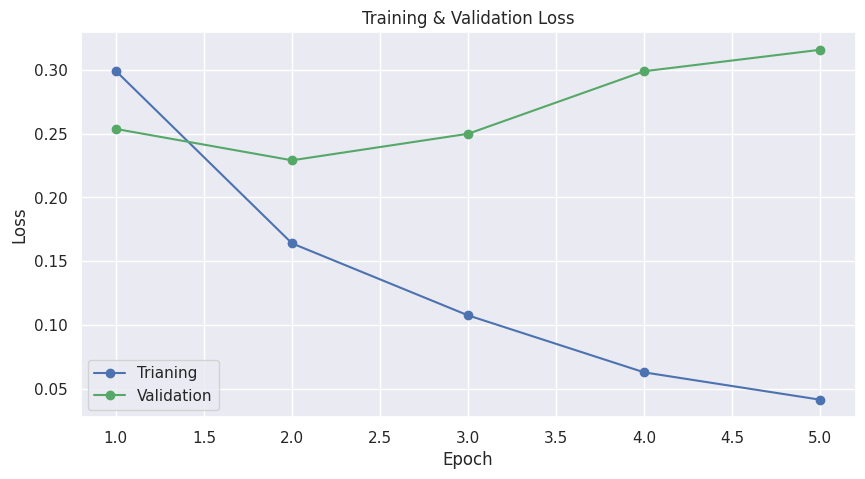

In [58]:
sns.set(style = 'darkgrid')
plt.figure(figsize = (10, 5))
plt.plot(df_train_info['training loss'], 'b-o', label = 'Trianing')
plt.plot(df_train_info['eval loss'], 'g-o', label = 'Validation')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
final_eval_accuracy = df_train_info['eval accuracy'].mean()
print(f"final eval accuracy: {final_eval_accuracy:.4f}")

final eval accuracy: 0.9478


In [60]:
from sklearn.metrics import f1_score

preds, gts = [], []

for _, sample in enumerate(eval_dataloader):
    
    input_ids = sample['input_ids'].to(device)
    attention_mask = sample['attention_mask'].to(device)
    labels = sample['labels'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, 
                        token_type_ids = None,
                        attention_mask = attention_mask,
                        labels = labels)
        loss = outputs.loss
        total_eval_loss += loss.item()
        
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()
        gts.extend(labels)
        pred = np.argmax(logits, axis = 1)
        preds.extend(pred)

# F1 score 계산
final_f1 = f1_score(gts, preds)
print(f"Test Data F1 Score: {final_f1}")

Test Data F1 Score: 0.9413118527042578


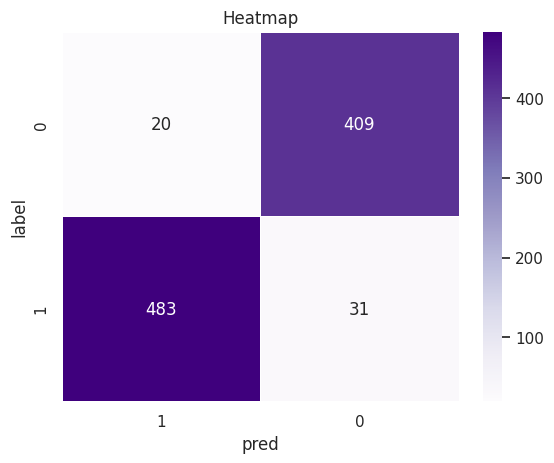

In [61]:
test_df = pd.DataFrame({'pred': preds, 'label': gts})
test_df

confusion_matrix = pd.crosstab(test_df['label'], test_df['pred'])
confusion_matrix.index = test_df['pred'].unique()
confusion_matrix.columns = test_df['label'].unique()
confusion_matrix = confusion_matrix.iloc[::-1, :]

sns.heatmap(confusion_matrix, cmap = 'Purples', annot = True, linewidth = .5, fmt = ".0f")
plt.title("Heatmap")
plt.ylabel("label")
plt.xlabel("pred")
plt.show()

In [62]:
torch.save(model.state_dict(), 'klue-bert-fine-tuned.pth')